In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [32]:
def plot_feature_importance(columns, weights, model_name, horizontal_line=None, k=20):
    dct = {c: w for c, w in zip(columns, weights)}
    plt.figure(figsize=(15, 8))
    top_results = sorted(dct.items(), key=lambda x: np.abs(x[1]), reverse=True)[:k]
    plt.bar([x[0] for x in top_results], [float(x[1]) for x in top_results], color='royalblue')
    if horizontal_line is not None:
        plt.axhline(y=horizontal_line, color='k', linestyle='--')
    plt.xticks(rotation=45)
    plt.title(f'{model_name} Statistical Feature Importance', fontsize=25)
    plt.show()

In [52]:
def plot_raw_feature_importance(original_columns, columns, weights, model_name, k=20):
    dct = dict()
    
    for col in original_columns:
        dct[col] = np.mean([np.abs(weights[i]) for i in range(len(columns)) if col in columns[i]])
    
    plt.figure(figsize=(15, 8))
    top_results = sorted(dct.items(), key=lambda x: np.abs(x[1]), reverse=True)[:k]
    plt.bar([x[0] for x in top_results], [float(x[1]) for x in top_results], color='teal')
    plt.xticks(rotation=45)
    plt.title(f'{model_name} Raw Feature Importance', fontsize=25)
    plt.show()

In [47]:
def plot_feature_group_importance(original_columns, columns, weights, model_name, use_iculos=True, k=20):
    vital_signs_columns = original_columns[:8]
    lab_values_columns = original_columns[8:34]
    if use_iculos:
        demographic_columns = original_columns[34:39]
    else:
        demographic_columns = original_columns[34:38]
    groups = {'vital_signs': vital_signs_columns, 'lab_value': lab_values_columns, 'demographic': demographic_columns}
    
    dct = dict()
    for group_name, feature_group in groups.items():
        cur_res = 0
        cur_items = 0
        for col in feature_group:
            tmp = [np.abs(weights[i]) for i in range(len(columns)) if col in columns[i]]
            cur_res += np.sum(tmp)
            cur_items += len(tmp)
        dct[group_name] = cur_res / cur_items
    
    plt.figure(figsize=(9, 5))
    top_results = sorted(dct.items(), key=lambda x: np.abs(x[1]), reverse=True)[:k]
    plt.bar([x[0] for x in top_results], [float(x[1]) for x in top_results], color='darkslateblue')
    plt.xticks(rotation=45)
    plt.title(f'{model_name} Feature-Group Importance', fontsize=20)
    plt.show()

In [6]:
with open('models/results.pkl', 'rb') as f:
    results = pickle.load(f)

with open('models/log_reg.model', 'rb') as f:
    log_reg = pickle.load(f)
    
with open('models/random_forest.model', 'rb') as f:
    random_forest = pickle.load(f)

with open('models/random_forest_columns', 'rb') as f:
    columns = pickle.load(f)
    
filepath = 'data/train/patient_0.psv'
original_columns = list(pd.read_csv(filepath, delimiter='|').drop(columns=['SepsisLabel', 'Unit2']).columns)

In [13]:
# pd.set_option("display.precision", 3)
# results.set_index('model_name').drop(columns=['train_accuracy', 'test_accuracy'])

# Interpretability

Besides predicting label for a new patient, the models we trained encodes additional information regarding feature importances.
<br>Different models encodes this information in different forms, and we will focus on exploring the feature importances learned by Logistic Regression and Random Forest models. <br>
Since Logistic Regression is a linear classifier, it will assign high importance to the features with strong linear relationship with the target, while Random Forest is a tree-based classifier, and we expect it to learn different (and potentially more complex) relationships.<br>
In the following analysis we will adress the importance of features in different granularities:
* Statistical features - statistic for each raw feature (acctual features used in the model)
* Raw features - features from original dataset (as aggregation of the statistical features importances)
* Feature-groups - groups of raw features (as aggregation of the statistical features importances)

## Feature Importance Definition

For the Logistic Regression model, we define the importance of a feature by the absolute value of the corresponding coeffitient.
<br>For the Random Forest model, the importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature.

### Distribution of importances per model

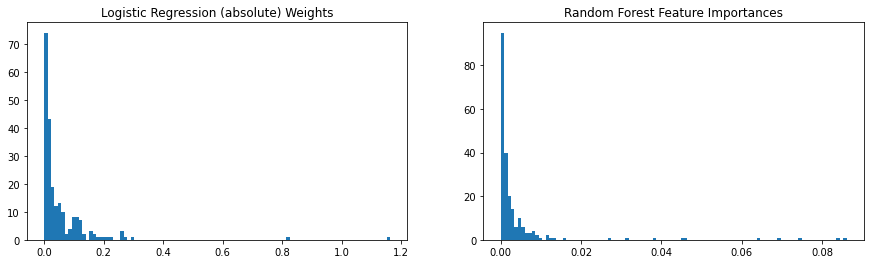

In [19]:
plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
plt.hist(np.abs(log_reg.coef_[0]), bins=100)
plt.title('Logistic Regression (absolute) Weights')
plt.subplot(1, 2, 2)
plt.hist(random_forest.feature_importances_, bins=100)
plt.title('Random Forest Feature Importances')
plt.show()

In both models, most statistical features have low importance (importance "score" close to 0),
and only a few are significantly important.

## Statistical Feature Importance

The following 2 plots visaulize the 20 most important statistical features used by each model (Logistic Regression, Random Forest).

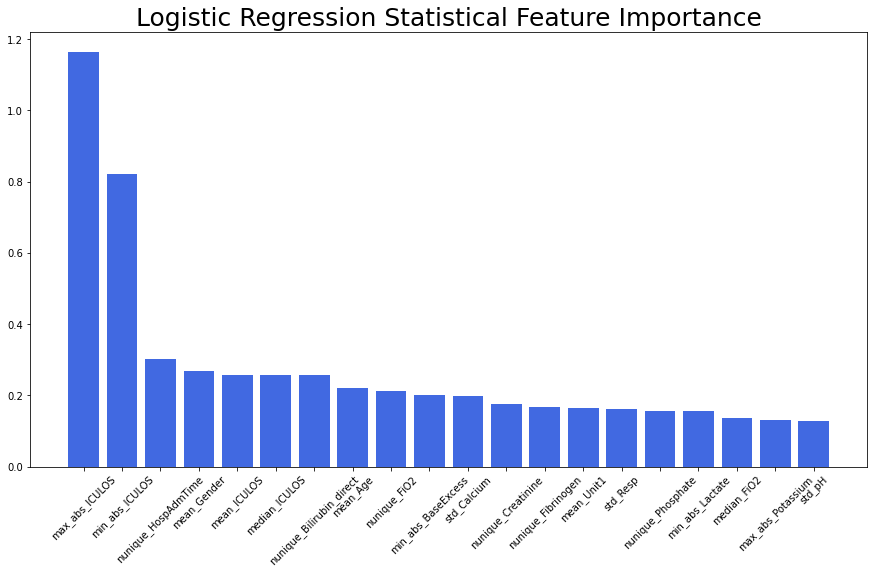

In [39]:
plot_feature_importance(columns=columns, weights=np.abs(log_reg.coef_[0]), model_name='Logistic Regression')

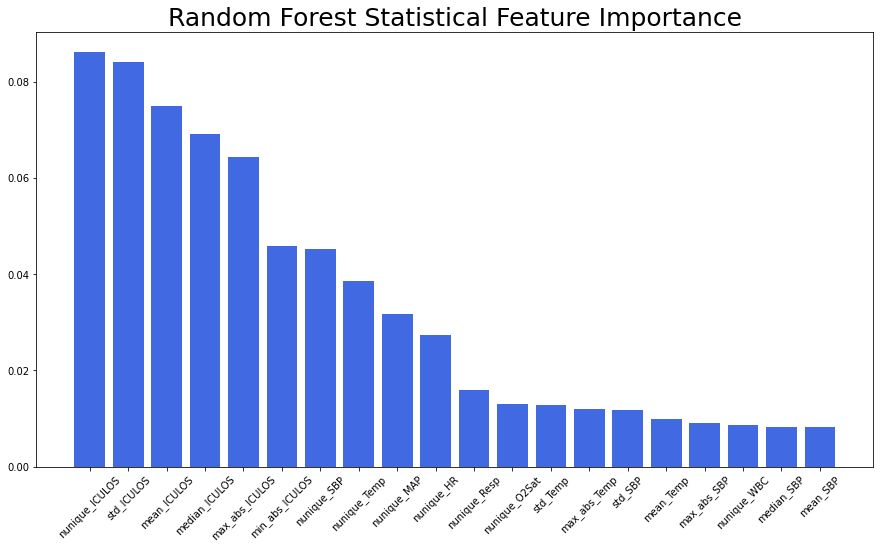

In [22]:
plot_feature_importance(columns=columns, weights=random_forest.feature_importances_, model_name='Random Forest')

Note that both models modeled the feature 'ICULOS' as the most important feature. 
Notice that many important statistical features are similar to a "counter of timesteps", which indicates that number of timesteps is an important feature for both models.

#### Lab Values
Next, we will plot the statistical feature importance only for the lab-values feature group (dahsed line is the median importance over all statistical features):

In [26]:
lab_values_indices = []
lab_values_columns = original_columns[8:34]

for lab_col in lab_values_columns:
    lab_values_indices += [i for i, col in enumerate(columns) if lab_col in col]

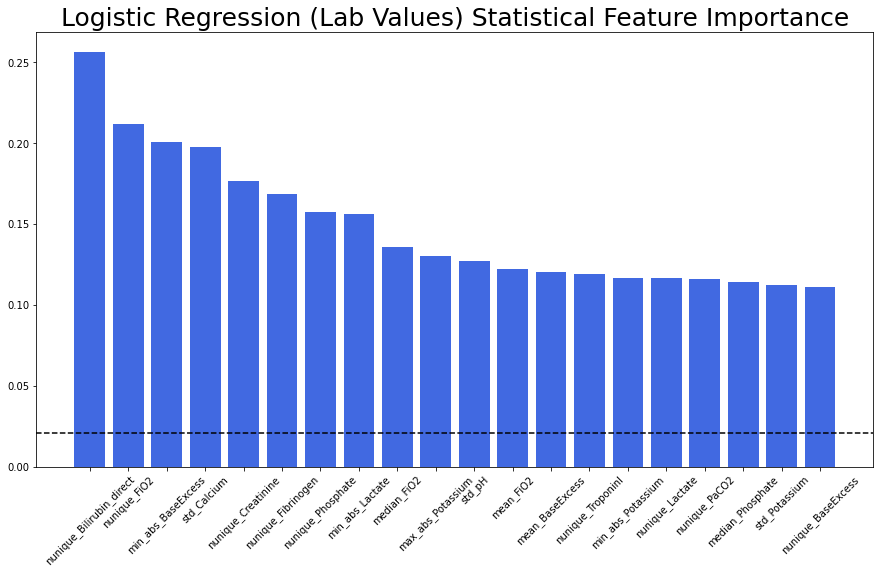

In [38]:
plot_feature_importance(columns=np.array(columns)[lab_values_indices], weights=np.abs(log_reg.coef_[0][lab_values_indices]), 
                        model_name='Logistic Regression (Lab Values)', horizontal_line=np.median(np.abs(log_reg.coef_[0])))

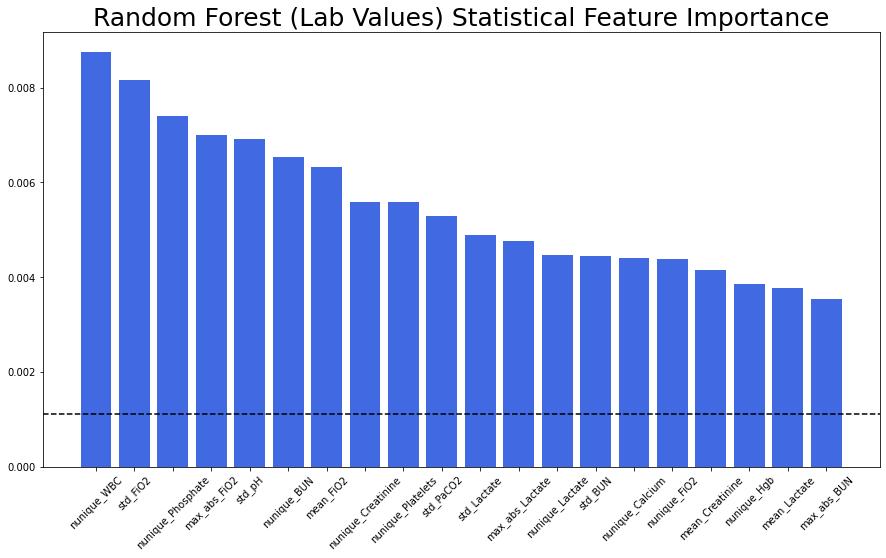

In [35]:
plot_feature_importance(columns=np.array(columns)[lab_values_indices], weights=random_forest.feature_importances_[lab_values_indices], 
                        model_name='Random Forest (Lab Values)', horizontal_line=np.median(random_forest.feature_importances_))

Notice that as we have expected (while decided on imputation policy and feature engineering), nunique is an important statistic on lab values features. This is because it encodes that a doctor found it valueable to perform this lab test.

## Raw Features Importance

The following 2 plots aggregate the raw feature importance as the mean of all statistc-features importance associated with this raw feature.

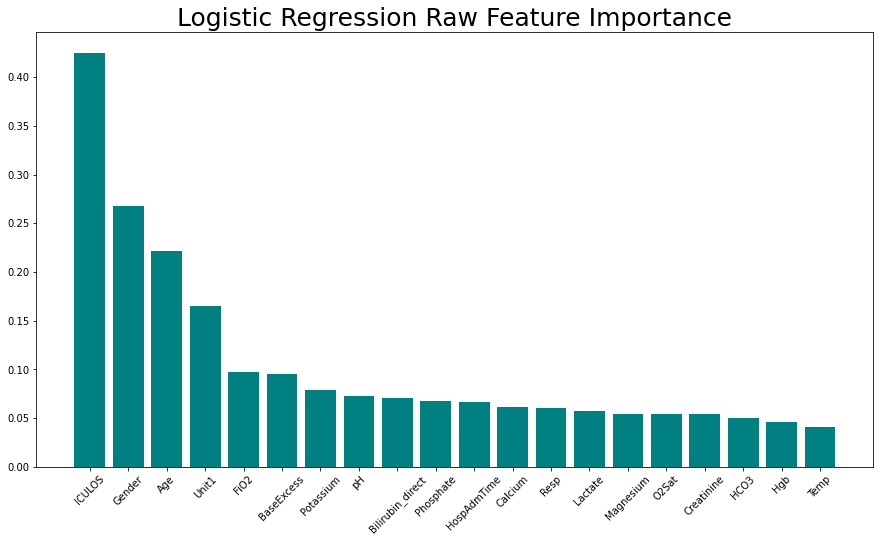

In [53]:
plot_raw_feature_importance(original_columns=original_columns, columns=columns, weights=log_reg.coef_[0], model_name='Logistic Regression')

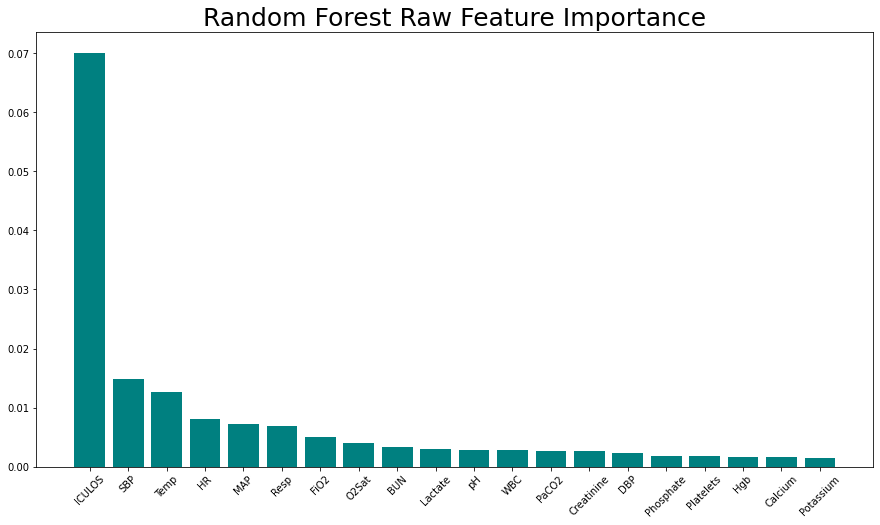

In [43]:
plot_raw_feature_importance(original_columns=original_columns, columns=columns, weights=random_forest.feature_importances_, model_name='Random Forest')

We can see a big difference between most important features between the models (except ICULOS). The Logistic Regression model assigns high weights to Gender and Age features, whereas Random Forest mostly uses vital signs (and lab values) for prediction.

## Feature-Group Importance

In the following 2 plots we visualize the aggregated importance of each feature group (vital signs, lab values, demographic)

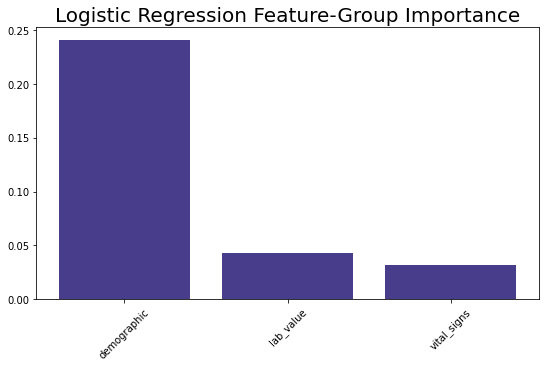

In [45]:
plot_feature_group_importance(original_columns=original_columns, columns=columns, weights=log_reg.coef_[0], model_name='Logistic Regression')

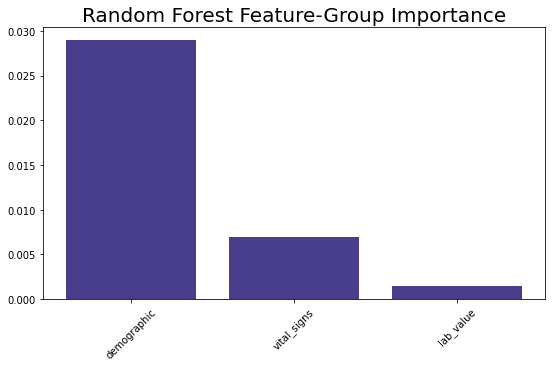

In [46]:
plot_feature_group_importance(original_columns=original_columns, columns=columns, weights=random_forest.feature_importances_, model_name='Random Forest')

The ICULOS feature is a part of the demographic feature-group, therefore it dominants the importance of this group.<br>
Notice that when ingoring the ICULOS feature, a different picture is obtained:

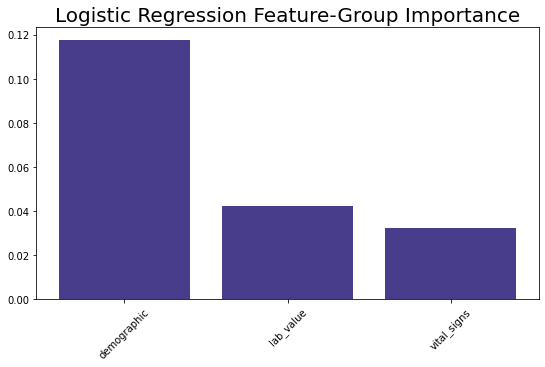

In [48]:
plot_feature_group_importance(original_columns=original_columns, columns=columns, weights=log_reg.coef_[0],
                              model_name='Logistic Regression', use_iculos=False)

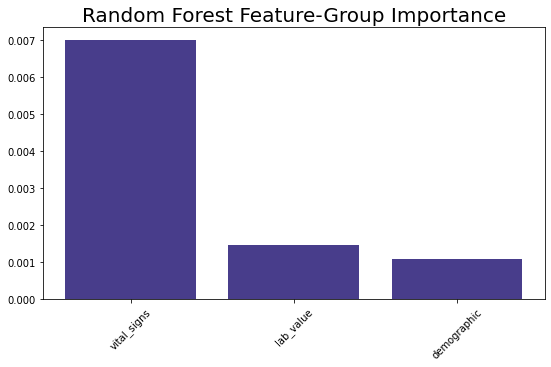

In [49]:
plot_feature_group_importance(original_columns=original_columns, columns=columns, weights=random_forest.feature_importances_, 
                              model_name='Random Forest', use_iculos=False)

While Logistic Regression still assigns more weight to demographic features (e.g. Age, Gender), in Random Forest, we see that vital signs are more dominant. Moreover, demographic (excluding ICULOS) are less important than lab values features (for Random Forest).